# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [104]:
import os
import sys
import random
import math
import time
import numpy as np
import tensorflow as tf
import skimage.io
import matplotlib
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
import matplotlib.pyplot as plt
from mrcnn import utils
from mrcnn import config
import argparse
import numpy as np
import mrcnn.model as modellib
import keras.backend as K
# import maskrcnn_predict_directed as mpd

dataS = utils.Dataset()


# Root directory of the project
ROOT_DIR = os.path.abspath("../")
DEFAULT_DATASET_YEAR = "2014"
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")



configS = config.Config()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco
from samples.coco import coco

%matplotlib inline

COCO_DIR = r'D:\HP\Downloads\ODS\rcnn\samples\coco'

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
ANNOTATION_FILE = r'D:\HP\Downloads\ODS\rcnn\samples\coco\annotations\instances_train2014.json'

## Configurations


In [105]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [106]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

In [107]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

Processing 1 images
image                    shape: (426, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


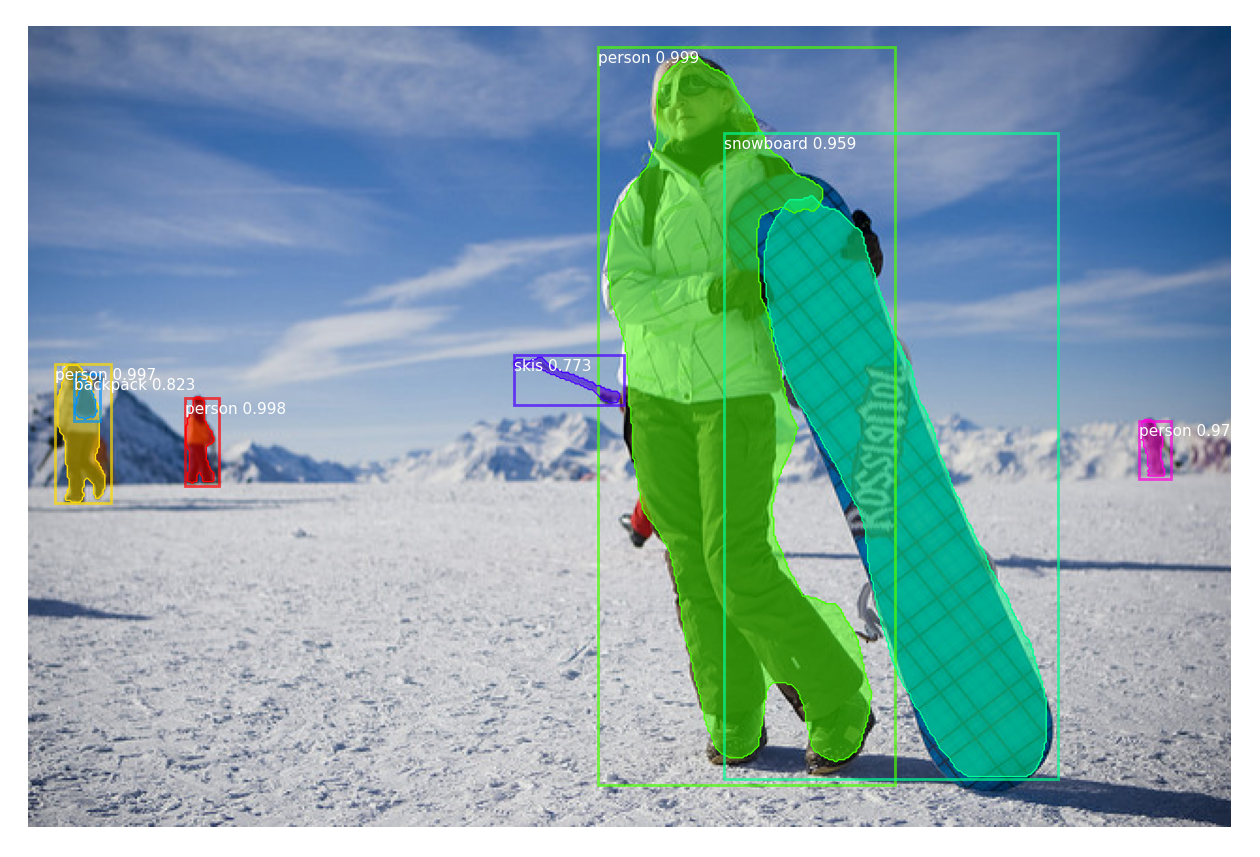

In [108]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [109]:

def build_coco_results(dataset, image_ids, rois, class_ids, scores, masks):
    """Arrange resutls to match COCO specs in http://cocodataset.org/#format
    """
    # If no results, return an empty list
    if rois is None:
        return []

    results = []
    for image_id in image_ids:
        # Loop through detections
        for i in range(rois.shape[0]):
            class_id = class_ids[i]
            score = scores[i]
            bbox = np.around(rois[i], 1)
            mask = masks[:, :, i]

            result = {
                "image_id": image_id,
                "category_id": dataset.get_source_class_id(class_id, "coco"),
                "bbox": [bbox[1], bbox[0], bbox[3] - bbox[1], bbox[2] - bbox[0]],
                "score": score,
                "segmentation": maskUtils.encode(np.asfortranarray(mask))
            }
            results.append(result)
    return results


In [110]:
def evaluate_coco(model, dataset, coco, eval_type="bbox", limit=0, image_ids=None):
    """Runs official COCO evaluation.
    dataset: A Dataset object with valiadtion data
    eval_type: "bbox" or "segm" for bounding box or segmentation evaluation
    limit: if not 0, it's the number of images to use for evaluation
    """
    # Pick COCO images from the dataset
    image_ids = image_ids or dataset.image_ids

    # Limit to a subset
    if limit:
        image_ids = image_ids[:limit]

    # Get corresponding COCO image IDs.
    coco_image_ids = [dataset.image_info[id]["id"] for id in image_ids]

    t_prediction = 0
    t_start = time.time()

    results = []
    for i, image_id in enumerate(image_ids):
        # Load image
        image = dataset.load_image(image_id)

        # Run detection
        t = time.time()
        r = model.detect([image], verbose=0)[0]
        t_prediction += (time.time() - t)

        # Convert results to COCO format
        # Cast masks to uint8 because COCO tools errors out on bool
        image_results = build_coco_results(dataset, coco_image_ids[i:i + 1],
                                           r["rois"], r["class_ids"],
                                           r["scores"],
                                           r["masks"].astype(np.uint8))
        results.extend(image_results)

    # Load results. This modifies results with additional attributes.
    coco_results = coco.loadRes(results)

    # Evaluate
    cocoEval = COCOeval(coco, coco_results, eval_type)
    cocoEval.params.imgIds = coco_image_ids
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

    print("Prediction time: {}. Average {}/image".format(
        t_prediction, t_prediction / len(image_ids)))
    print("Total time: ", time.time() - t_start)

In [ ]:
# # Parse command line arguments
# parser = argparse.ArgumentParser(
#     description='Train Mask R-CNN on MS COCO.')
# parser.add_argument("command",
#                     metavar="<command>",
#                     help="'train' or 'evaluate' on MS COCO")
# parser.add_argument('--dataset', required=True,
#                     metavar="C:/Users/HTS PC/ODS/rcnn/samples/coco",
#                     help='Directory of the MS-COCO dataset')
# parser.add_argument('--year', required=False,
#                     default=DEFAULT_DATASET_YEAR,
#                     metavar="<year>",
#                     help='Year of the MS-COCO dataset (2014 or 2017) (default=2014)')
# parser.add_argument('--model', required=True,
#                     metavar="C:/Users/HTS PC/ODS/rcnn/mask_rcnn_coco.h5",
#                     help="Path to weights .h5 file or 'coco'")
# parser.add_argument('--logs', required=False,
#                     default=DEFAULT_LOGS_DIR,
#                     metavar="/path/to/logs/",
#                     help='Logs and checkpoints directory (default=logs/)')
# parser.add_argument('--limit', required=False,
#                     default=500,
#                     metavar="<image count>",
#                     help='Images to use for evaluation (default=500)')
# parser.add_argument('--download', required=False,
#                     default=False,
#                     metavar="<True|False>",
#                     help='Automatically download and unzip MS-COCO files (default=False)',
#                     type=bool)
# args = parser.parse_args()

In [111]:
dataset_val = coco.CocoDataset()
evaluate_coco(model, dataset_val, coco, "bbox", limit=int(4))

AttributeError: module 'samples.coco.coco' has no attribute 'loadRes'

In [112]:
def evaluate_model(dataset, model, cfg):
    APs = list(); 
    ARs = list();
    F1_scores = list(); 
    for image_id in dataset.image_ids:
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        #image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id)
        scaled_image = modellib.mold_image(image, cfg)
        sample = np.expand_dims(scaled_image, 0)
        yhat = model.detect(sample, verbose=0)
        r = yhat[0]
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        AR, positive_ids = utils.compute_recall(r["rois"], gt_bbox, iou=0.2)
        ARs.append(AR)
        F1_scores.append((2* (np.mean(precisions) * np.mean(recalls)))/(np.mean(precisions) + np.mean(recalls)))
        APs.append(AP)

    mAP = np.mean(APs)
    mAR = np.mean(ARs)
    return mAP, mAR, F1_scores

In [ ]:
from mrcnn.config import Config as cfgs
dataset_val = coco.CocoDataset()

evaluate_model(dataset_val,model, cfgs)

In [ ]:
#dataset_val = utils.Dataset
#configS = mpd.SimpleConfig

#mAP, mAR, F1_score = evaluate_model(dataset_val, model, configS)
#print("Precisión Media mAP (mean average precision): %.4f" % mAP)
#print("Recall Promedio mAR: (mean average recall): %.4f" % mAR)

#F1_score_2 = (2 * mAP * mAR)/(mAP + mAR)
#print('F1-score : ', F1_score_2)

In [113]:
SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


## Load Validation Dataset
Ensure you download wget so as to download annotations file

In [ ]:
%winget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
%unzip annotations_trainval2014.zip
%cd annotations/instances_val2014.json annotations/instances_minival2014.json

In [114]:
# Build validation dataset
if config.NAME == 'shapes':
    dataset =  coco.CocoDataset()
    dataset.load_coco(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
elif config.NAME == "coco":
    dataset = coco.CocoDataset()
    dataset.load_coco(COCO_DIR, "minival")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

loading annotations into memory...
Done (t=17.27s)
creating index...
index created!
Images: 4952
Classes: ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [115]:
DEVICE = "/cpu:0" 
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Set weights file path
if config.NAME == "shapes":
    weights_path = SHAPES_MODEL_PATH
elif config.NAME == "coco":
    weights_path = COCO_MODEL_PATH
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  d:\HP\Downloads\ODS\rcnn\mask_rcnn_coco.h5


image ID: coco.34417 (279) http://cocodataset.org/#explore?id=34417
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


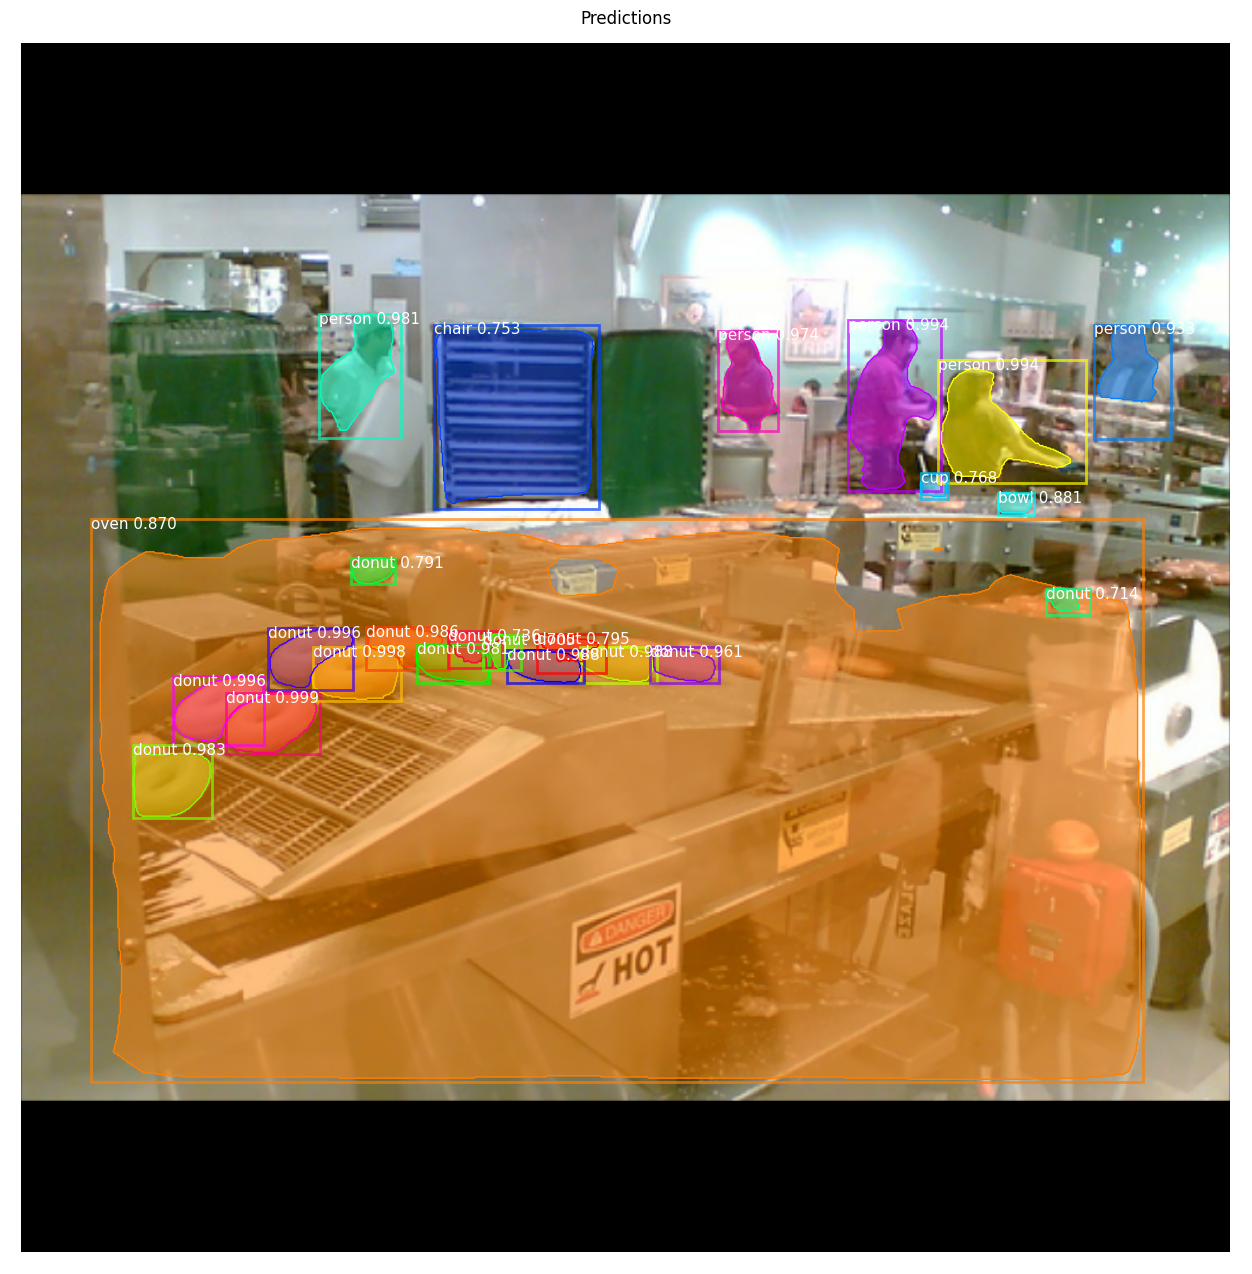

In [150]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
#log("gt_class_id", gt_class_id)
#log("gt_bbox", gt_bbox)
#log("gt_mask", gt_mask)

Precision-Recall

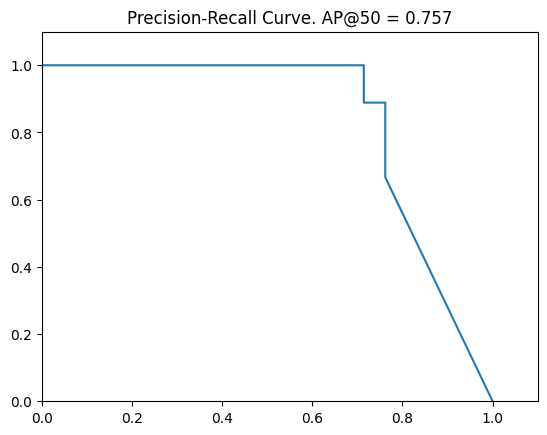

In [151]:
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

Compute mAP @ IoU=500 on Batch of Images

In [138]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    ARs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        AR, _ = utils.compute_recall(r["rois"], gt_bbox, iou=0.5)

        APs.append(AP)
        ARs.append(AR)
    return APs,ARs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 10)
APs,ARs = compute_batch_ap(image_ids)
print("mAP @ IoU=500: ", np.mean(APs))
print("mAR @ iou=1 ", np.mean(ARs))

mAP @ IoU=500:  0.7423216365319837
mAR @ iou=1  0.8192307692307692


In [139]:
APs, ARs = compute_batch_ap(image_ids)
F1_score = ((2* (np.mean(APs) * np.mean(ARs)))/(np.mean(APs) + np.mean(ARs)))
print('F1 score: ', F1_score)

F1 score:  0.7788822495722685
